# Path Integral Methods

## Density Matrices

### Quantum Harmonic Oscillator

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.core.pylabtools import figsize

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


def harmonic_wavefunction(n,x):
    if n==-1:
        return 0
    if n==0:
        return np.pi**(-1.0/4) * np.exp(-x**2/2.0)
    return np.sqrt(2.0/n)*x*harmonic_wavefunction(n-1,x)-np.sqrt((n-1.0)/n)*harmonic_wavefunction(n-2,x)

harmonic_wavefunction_vectorise = np.vectorize(harmonic_wavefunction)

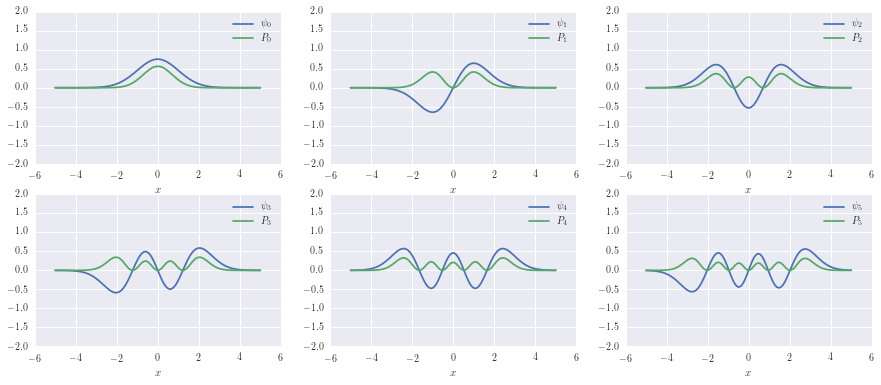

In [4]:
number_columns=3
number_rows=2
figsize(15, 6)
xs=np.linspace(-5,5,100)

for i,j in enumerate([(i/number_columns,i%number_columns) for i in range(number_columns*number_rows)]):
    plt.subplot2grid((number_rows,number_columns),j)
    plt.plot(xs,harmonic_wavefunction_vectorise(i,xs),"-",label=r"$\psi_"+str(i)+"$")
    plt.plot(xs,harmonic_wavefunction_vectorise(i,xs)**2,"-",label=r"$P_"+str(i)+"$")
    plt.xlabel(r"$x$")
    plt.ylim(-2,2)
    plt.legend()

plt.show()

Check normalization of probability

In [5]:
[np.sum(harmonic_wavefunction(i,xs)**2*(xs[5]-xs[4])) for i in range(6)]

[0.99999999999912503,
 0.99999999995337963,
 0.9999999988055871,
 0.99999998037401061,
 0.99999976782077959,
 0.99999789581845122]

The probability of being at a location $x$ for an energy eigenstate given by $n$ is just $|\psi_n(x)|^2$. In the canonical ensemble we need to sum this with the Boltzman factor

In [23]:
def harmonic_density(beta,x,xp,nmax=10):
    rho=0.0
    for i in range(nmax):
        rho=rho+np.exp(-beta*i)*harmonic_wavefunction(i,x)*harmonic_wavefunction(i,xp)
    return rho

def probability(beta,x,nmax=10):
    rho=harmonic_density(beta,x,x,nmax)
    Z=np.sum(rho*(x[1]-x[0]))
    return rho/Z
    

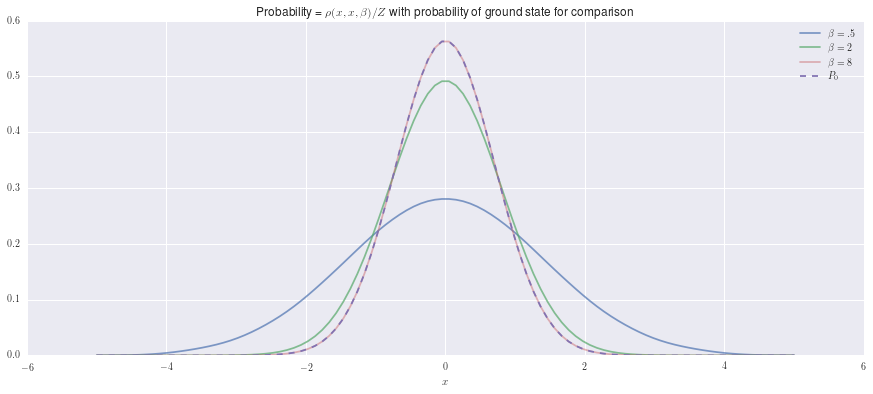

In [24]:
plt.plot(xs,probability(.5,xs),label=r"$\beta=.5$",alpha=.7)
plt.plot(xs,probability(2,xs),label=r"$\beta=2$",alpha=.7)
plt.plot(xs,probability(8,xs),label=r"$\beta=8$",alpha=.4)
plt.plot(xs,harmonic_wavefunction_vectorise(0,xs)**2,"--",label=r"$P_"+str(0)+"$")
plt.xlabel(r"$x$")
plt.title(r"Probability = $\rho(x,x,\beta)/Z$ with probability of ground state for comparison")
plt.legend()

The **exact expression for the harmonic oscillator density function** is given by

$$
\rho(x,x',\beta)= \sqrt{\frac{1}{2 \pi \sinh \beta}} exp\left(-\frac{(x+x')^2}{4} \tanh \frac{\beta}{2}-\frac{(x-x')^2}{4} \coth \frac{\beta}{2}\right)
$$

and the partition function is

$$
Z= \int dx ~\rho(x,x,\beta)= \frac{1}{2 \sinh(\beta/2)}
$$

We plot them again to see they match the results we got from explicit summing

In [28]:
def harmonic_density_exact(beta,x,xp):
    return np.sqrt(1/(2*np.pi*np.sinh(beta)))*np.exp(-(x+xp)**2/4.0*np.tanh(beta/2.0) - (x-xp)**2/4.0/np.tanh(beta/2.0))


def probability_exact(beta,x):
    rho=harmonic_density_exact(beta,x,x)
    return 2*np.sinh(beta/2.0)*rho

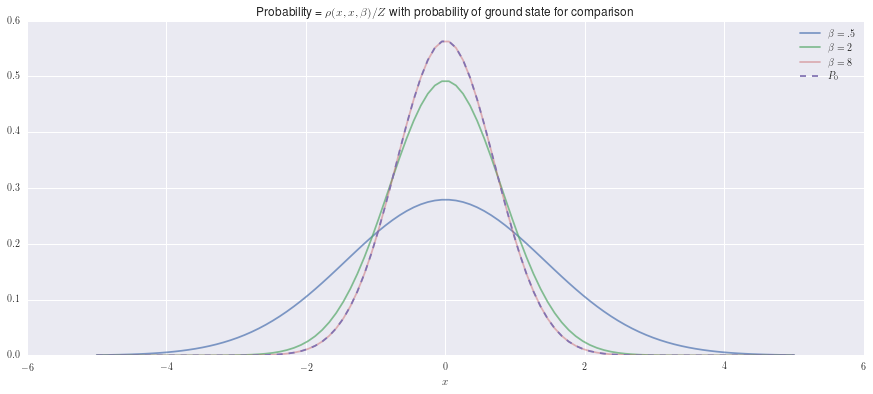

In [29]:
plt.plot(xs,probability_exact(.5,xs),label=r"$\beta=.5$",alpha=.7)
plt.plot(xs,probability_exact(2,xs),label=r"$\beta=2$",alpha=.7)
plt.plot(xs,probability_exact(8,xs),label=r"$\beta=8$",alpha=.4)
plt.plot(xs,harmonic_wavefunction_vectorise(0,xs)**2,"--",label=r"$P_"+str(0)+"$")
plt.xlabel(r"$x$")
plt.title(r"Probability = $\rho(x,x,\beta)/Z$ with probability of ground state for comparison")
plt.legend()

Furthermore we check the convolution property 

$$
\rho(x,x,2 \beta) = \int dx' \rho(x,x',\beta) \rho(x',x,\beta)
$$

graphically

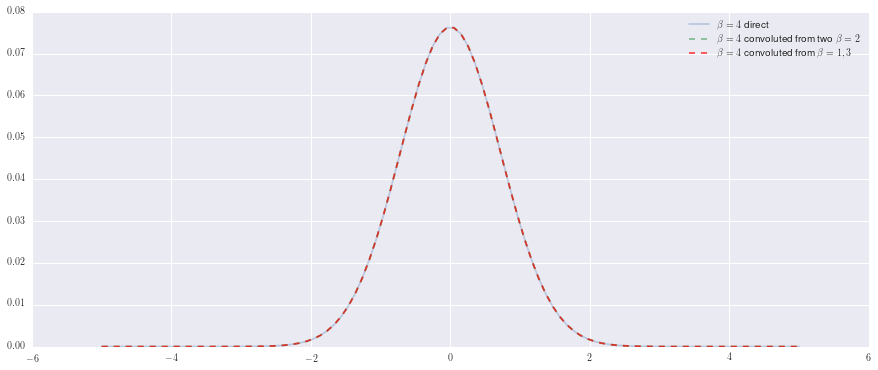

In [39]:
first=harmonic_density_exact(4,xs,xs)
second=np.array([np.sum([harmonic_density_exact(2,x1,x2)*harmonic_density_exact(2,x2,x1) for x2 in xs])*(xs[1]-xs[0]) for x1 in xs])
third=np.array([np.sum([harmonic_density_exact(1,x1,x2)*harmonic_density_exact(3,x2,x1) for x2 in xs])*(xs[1]-xs[0]) for x1 in xs])


plt.plot(xs,first,"-",label=r"$\beta=4$ direct",alpha=.3)
plt.plot(xs,second,"--",label=r"$\beta=4$ convoluted from two $\beta=2$",alpha=.7)
plt.plot(xs,third,"r--",label=r"$\beta=4$ convoluted from $\beta=1,3$",alpha=.7)


plt.legend()

